## Install the package dependencies before running this notebook

In [74]:
import torch
from torch.utils.data import Dataset, DataLoader
import os, os.path 
import numpy 
import pickle
from glob import glob

"""
    number of trajectories in each city
    # austin --  train: 43041 test: 6325 
    # miami -- train: 55029 test:7971
    # pittsburgh -- train: 43544 test: 6361
    # dearborn -- train: 24465 test: 3671
    # washington-dc -- train: 25744 test: 3829
    # palo-alto -- train:  11993 test:1686

    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds
    
"""

'\n    number of trajectories in each city\n    # austin --  train: 43041 test: 6325 \n    # miami -- train: 55029 test:7971\n    # pittsburgh -- train: 43544 test: 6361\n    # dearborn -- train: 24465 test: 3671\n    # washington-dc -- train: 25744 test: 3829\n    # palo-alto -- train:  11993 test:1686\n\n    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds\n    \n'

## Create a Torch.Dataset class for the training dataset

In [75]:
from glob import glob
import pickle
import numpy as np

ROOT_PATH = "./"

cities = ["austin", "miami", "pittsburgh", "dearborn", "washington-dc", "palo-alto"]
splits = ["train", "test"]

def get_city_trajectories(city="palo-alto", split="train", normalized=False):
    f_in = ROOT_PATH + split + "/" + city + "_inputs"
    inputs = pickle.load(open(f_in, "rb"))
    inputs = np.asarray(inputs)
    
    outputs = None
    
    if split=="train":
        f_out = ROOT_PATH + split + "/" + city + "_outputs"
        outputs = pickle.load(open(f_out, "rb"))
        outputs = np.asarray(outputs)

        trajectories = np.concatenate((inputs, outputs), axis=1)
        trajectories = trajectories.reshape(-1, trajectories.shape[1], trajectories.shape[2])
        trajectories = trajectories.astype(np.float32)

        inputs = []
        outputs = []
        for trajectory in trajectories:
            for i in range(trajectory.shape[0] - 50):
                inputs.append(trajectory[i:i+50])
                outputs.append(trajectory[i+50])

    inputs, outputs = np.asarray(inputs), np.asarray(outputs)
    return inputs, outputs

class ArgoverseDataset(Dataset):
    """Dataset class for Argoverse"""
    def __init__(self, city: str, split:str, transform=None):
        super(ArgoverseDataset, self).__init__()
        self.transform = transform

        self.inputs, self.outputs = get_city_trajectories(city=city, split=split, normalized=False)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):

        data = (self.inputs[idx], self.outputs[idx])
            
        if self.transform:
            data = self.transform(data)

        return data

# intialize each dataset
train_austin = ArgoverseDataset(city = "austin", split = "train")
train_miami = ArgoverseDataset(city = "miami", split = "train")
train_palo_alto = ArgoverseDataset(city = "palo-alto", split = "train")
train_pittsburgh = ArgoverseDataset(city = "pittsburgh", split = "train")
train_dearborn = ArgoverseDataset(city = "dearborn", split = "train")
train_washington_dc = ArgoverseDataset(city = "washington-dc", split = "train")
test_austin = ArgoverseDataset(city = "austin", split = "test")
test_miami = ArgoverseDataset(city = "miami", split = "test")
test_palo_alto = ArgoverseDataset(city = "palo-alto", split = "test")
test_pittsburgh = ArgoverseDataset(city = "pittsburgh", split = "test")
test_dearborn = ArgoverseDataset(city = "dearborn", split = "test")
test_washington_dc = ArgoverseDataset(city = "washington-dc", split = "test")


## Create a DataLoader class for training

In [76]:
batch_sz = 10  # batch size 
train_loader = DataLoader(train_palo_alto,batch_size=batch_sz)

## Sample a batch of data and visualize 

torch.Size([10, 50, 2]) torch.Size([10, 2])


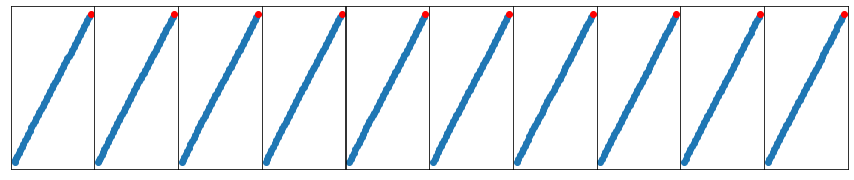

In [77]:
import matplotlib.pyplot as plt
import random


def show_sample_batch(sample_batch):
    """visualize the trajectory for a batch of samples"""
    inp, out = sample_batch
    batch_sz = inp.size(0)
    agent_sz = inp.size(1)

    
    fig, axs = plt.subplots(1,batch_sz, figsize=(15, 3), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5, wspace=.001)
    axs = axs.ravel()   
    for i in range(batch_sz):
        axs[i].xaxis.set_ticks([])
        axs[i].yaxis.set_ticks([])
        
        # first two feature dimensions are (x,y) positions
        axs[i].scatter(inp[i,:,0], inp[i,:,1])
        axs[i].scatter(out[i,0], out[i,1], c='r')
    

for i_batch, sample_batch in enumerate(train_loader):
    inputs, outputs = sample_batch
    show_sample_batch(sample_batch)
    print(inputs.shape, outputs.shape)
    break




## Create Model

In [78]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

from torch import nn

class LSTM(nn.Module):
    def __init__(self):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=2, hidden_size=512, num_layers=3, batch_first=True)
        self.dropout = nn.Dropout(0.5)
        self.linear = nn.Linear(512, 256)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(256, 2)
        self.leakyrelu = nn.LeakyReLU()

    def forward(self, x, h=None, c=None):
        if (h is not None) and (c is not None):
            x, (h, c) = self.lstm(x, (h, c))
        else:
            x, (h, c) = self.lstm(x)
        x = self.dropout(x)
        x = self.linear(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.leakyrelu(x)
        return x, h, c

    def predict(self, x, h=None, c=None):
        output, h, c = self.forward(x, h, c)
        output = output[-1]
        output = output.cpu().detach().numpy()
            
        return output, h, c
        

Using device: cpu


## Train Model

In [82]:
num_epochs = 60
learning_rate = 0.001

lstm = LSTM()
lstm.to(device)
optimizer = torch.optim.Adam(lstm.parameters(), learning_rate)
loss_fn = nn.MSELoss()

for epoch in range(num_epochs):
    lstm.train(True)
    for i_batch, sample_batch in enumerate(train_loader):
        inp, label = sample_batch
        
        inp = inp.to(device)
        output, h, c = lstm(inp.float())

        output = output[:, -1, :]

        loss = loss_fn(output, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if i_batch % 10 == 0:
            print(f"Epoch: {epoch}/{num_epochs}, Batch: {i_batch}/{len(train_loader)}, Loss: {loss.item()}")

    lstm.train(False)
    for i_batch, sample_batch in enumerate(test_loader):
        inp, label = sample_batch
        inp = inp.to(device)
        output, h, c = lstm(inp)
        loss = loss_fn(output, label)
        print(f"Epoch: {epoch}/{num_epochs}, Batch: {i_batch}/{len(test_loader)}, Loss: {loss.item()}")
        break
    break


        

torch.Size([10, 2]) torch.Size([10, 2])
Epoch: 0/60, Batch: 0/71958, Loss: 1511233.625
torch.Size([10, 2]) torch.Size([10, 2])
torch.Size([10, 2]) torch.Size([10, 2])
torch.Size([10, 2]) torch.Size([10, 2])


KeyboardInterrupt: 